In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions.one_hot_categorical as one_hot_sample

import queuetorch.env as env
from queuetorch.env import QueuingNetwork
import yaml
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt

In [4]:
name = 'criss_cross_bh'
with open(f'../configs/env/{name}.yaml', 'r') as f:
    env_config = yaml.safe_load(f)

In [5]:
# Policy Neural Network
class PolicyNet(nn.Module):
    def __init__(self, s, q, layers, hidden_dim):
        super().__init__()
        self.s = s
        self.q = q
        self.layers = layers
        self.hidden_dim = hidden_dim
        
        self.input_fc = nn.Linear(self.q, hidden_dim)    
        self.layers_fc = nn.ModuleList()
        for _ in range(layers):
            self.layers_fc.append(nn.Linear(hidden_dim, hidden_dim))
        self.output_fc = nn.Linear(hidden_dim, self.s * self.q)
        
    def forward(self, x):
        
        # Input layer
        batch = x.size()[0]
            
        x = F.relu(self.input_fc(x))

        # Hidden layer
        for l in range(self.layers):
            x = F.relu(self.layers_fc[l](x))

        # Output layer
        x = self.output_fc(x)
        return F.softmax(torch.reshape(x, (batch, self.s , self.q)), dim = 2)

# Train the policy

In [76]:
epochs = 10
seed = 42
train_batch = 1
train_horizon = 10000
temp = 0.1
lr = 8e-4

In [77]:
dq = env.load_env(env_config, temp = temp, batch = train_batch, seed = seed, device = 'cpu')
net = PolicyNet(s=dq.s,q=dq.q, layers = 2, hidden_dim = 128)
optimizer = torch.optim.Adam(params = net.parameters(), lr = lr)

In [78]:
obs, state = dq.reset(seed = 42)
init_train_queues = obs.queues.detach().clone()

for epoch in range(epochs):

    # zero out the optimizer
    optimizer.zero_grad()

    # Train loop
    obs, state = dq.reset(seed = epoch, init_queues = init_train_queues)
    total_cost = torch.tensor([[0.]]*train_batch)
    time_weight_queue_len = torch.tensor([[0.]]*train_batch)

    print(f'epoch:\t {epoch}')
    print(f'init queues:\t {obs.queues}')

    queues_path = []

    for _ in trange(train_horizon):
        queues, time = obs
        
        pr = net(queues)

        # work-conserving softmax
        pr = pr * dq.network
        pr = torch.minimum(pr, queues.unsqueeze(1).repeat(1, dq.s, 1))
        pr += 1*torch.all(pr == 0., dim = 2).reshape(train_batch,dq.s,1).repeat(1,1,dq.q) * dq.network
        pr /= torch.sum(pr, dim = -1).reshape(train_batch, dq.s, 1) 

        action = pr
        obs, state, cost, event_time = dq.step(state, action)
        
        total_cost = total_cost + cost
        
    # Backward
    loss = torch.mean(total_cost / train_horizon)
    loss.backward()

    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm = 1.0)
    optimizer.step()

    print(f"train cost:\t{torch.mean(total_cost / state.time)}")
    print()

    init_train_queues = obs.queues.detach().clone()

epoch:	 0
init queues:	 tensor([[0., 0., 0.]])


100%|██████████| 10000/10000 [00:02<00:00, 4092.41it/s]


train cost:	18.162076950073242

epoch:	 1
init queues:	 tensor([[ 0., 20.,  0.]])


100%|██████████| 10000/10000 [00:02<00:00, 4074.30it/s]


train cost:	14.473548889160156

epoch:	 2
init queues:	 tensor([[0., 3., 0.]])


100%|██████████| 10000/10000 [00:02<00:00, 4105.15it/s]


train cost:	11.234309196472168

epoch:	 3
init queues:	 tensor([[ 1., 11.,  0.]])


100%|██████████| 10000/10000 [00:02<00:00, 4063.02it/s]


train cost:	11.544288635253906

epoch:	 4
init queues:	 tensor([[1., 4., 0.]])


100%|██████████| 10000/10000 [00:02<00:00, 4217.58it/s]


train cost:	13.97566032409668

epoch:	 5
init queues:	 tensor([[13.,  5.,  4.]])


100%|██████████| 10000/10000 [00:02<00:00, 4300.27it/s]


train cost:	15.028116226196289

epoch:	 6
init queues:	 tensor([[16.,  2.,  3.]])


100%|██████████| 10000/10000 [00:02<00:00, 4041.33it/s]


train cost:	13.098245620727539

epoch:	 7
init queues:	 tensor([[1., 9., 0.]])


100%|██████████| 10000/10000 [00:02<00:00, 4042.43it/s]


train cost:	20.267610549926758

epoch:	 8
init queues:	 tensor([[0., 1., 2.]])


100%|██████████| 10000/10000 [00:02<00:00, 4206.48it/s]


train cost:	15.636051177978516

epoch:	 9
init queues:	 tensor([[15.,  8.,  1.]])


100%|██████████| 10000/10000 [00:02<00:00, 4108.11it/s]


train cost:	15.353425025939941



# Visualize the policy

Text(0.5, 0, 'Queue 1')

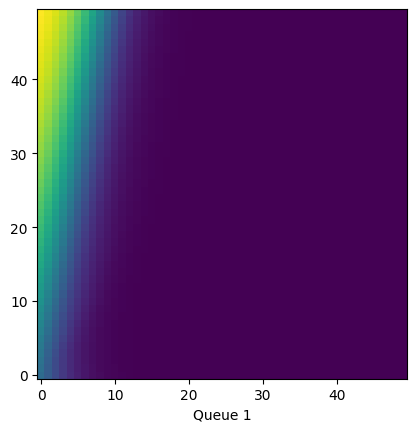

In [80]:
max_queue = 50
base_level = 0

X = np.arange(0, max_queue, 1)
Y = np.arange(0, max_queue, 1)
Z = np.zeros((max_queue,max_queue))

for i in range(max_queue):
    for j in range(max_queue):
        obs = torch.tensor([base_level]*dq.q)
        obs[0] = X[i]
        obs[1] = Y[j]

        obs = obs.float().unsqueeze(0).to('cpu')
        Z[i][j] = net(obs)[0][0][0]

plt.imshow(Z, interpolation='nearest', origin='lower')
plt.xlabel('Queue 0')
plt.xlabel('Queue 1')

# Test the policy

In [81]:
test_batch = 100
test_seed = 99999
test_horizon = 50000

In [82]:
# test

dq = env.load_env(env_config, temp = 0.1, batch = test_batch, seed = test_seed, device = 'cpu')

obs, state = dq.reset(seed = test_seed)
total_cost = torch.tensor([[0.]]*test_batch)

with torch.no_grad():
    for _ in trange(test_horizon):

        queues, time = obs
        pr = net(queues)

        # Work conserving softmax
        pr = pr * dq.network
        pr = torch.minimum(pr, queues.unsqueeze(1).repeat(1, dq.s, 1))
        pr += 1*torch.all(pr == 0., dim = 2).reshape(test_batch,dq.s,1).repeat(1,1,dq.q) * dq.network
        pr /= torch.sum(pr, dim = -1).reshape(test_batch, dq.s, 1)

        # Randomize
        action = one_hot_sample.OneHotCategorical(probs = pr).sample()

        obs, state, cost, event_time = dq.step(state, action)
        total_cost = total_cost + cost

    test_cost = torch.mean(total_cost / state.time)
    print(f"test cost: \t{test_cost}")

100%|██████████| 50000/50000 [00:23<00:00, 2102.27it/s]

test cost: 	16.250837326049805
